# Downsampling 10x Data
Here we attempt to downsample the 10x data to see if it is more concordant with the XYZeq data in terms of cell types and proportion of each cell type. If it is, we may consider using downsampled data, as we might argue it's a more apples-to-apples comparison.

In [2]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
import seaborn as sns

from IPython.display import display, HTML

In [3]:
print(sc.__version__)

1.5.1


In [4]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [5]:
prefix = '/data/xyzeq/box.data3/data/'

## Load in the Data

In [6]:
data = dict()
data['10x'] = dict()
data['XYZ'] = dict()
data['10x']['raw'] = sc.read_10x_h5(prefix + 'Liver/10X_raw_feature_bc_matrix.h5')
data['10x']['raw'].var_names_make_unique()
data['XYZ']['raw'] = sc.read_loom(prefix + 'Liver/L20C1_all_cells_mouse_genes.loom', validate=False)
data['XYZ']['raw'].var_names_make_unique()

reading /data/xyzeq/box.data3/data/Liver/10X_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Subset the 10x Cells
I want to capture as many of the 10x cells as possible. Because I only want to compare mouse cells, I'm going to keep only the cells with high counts of mouse genes and low counts of human genes.

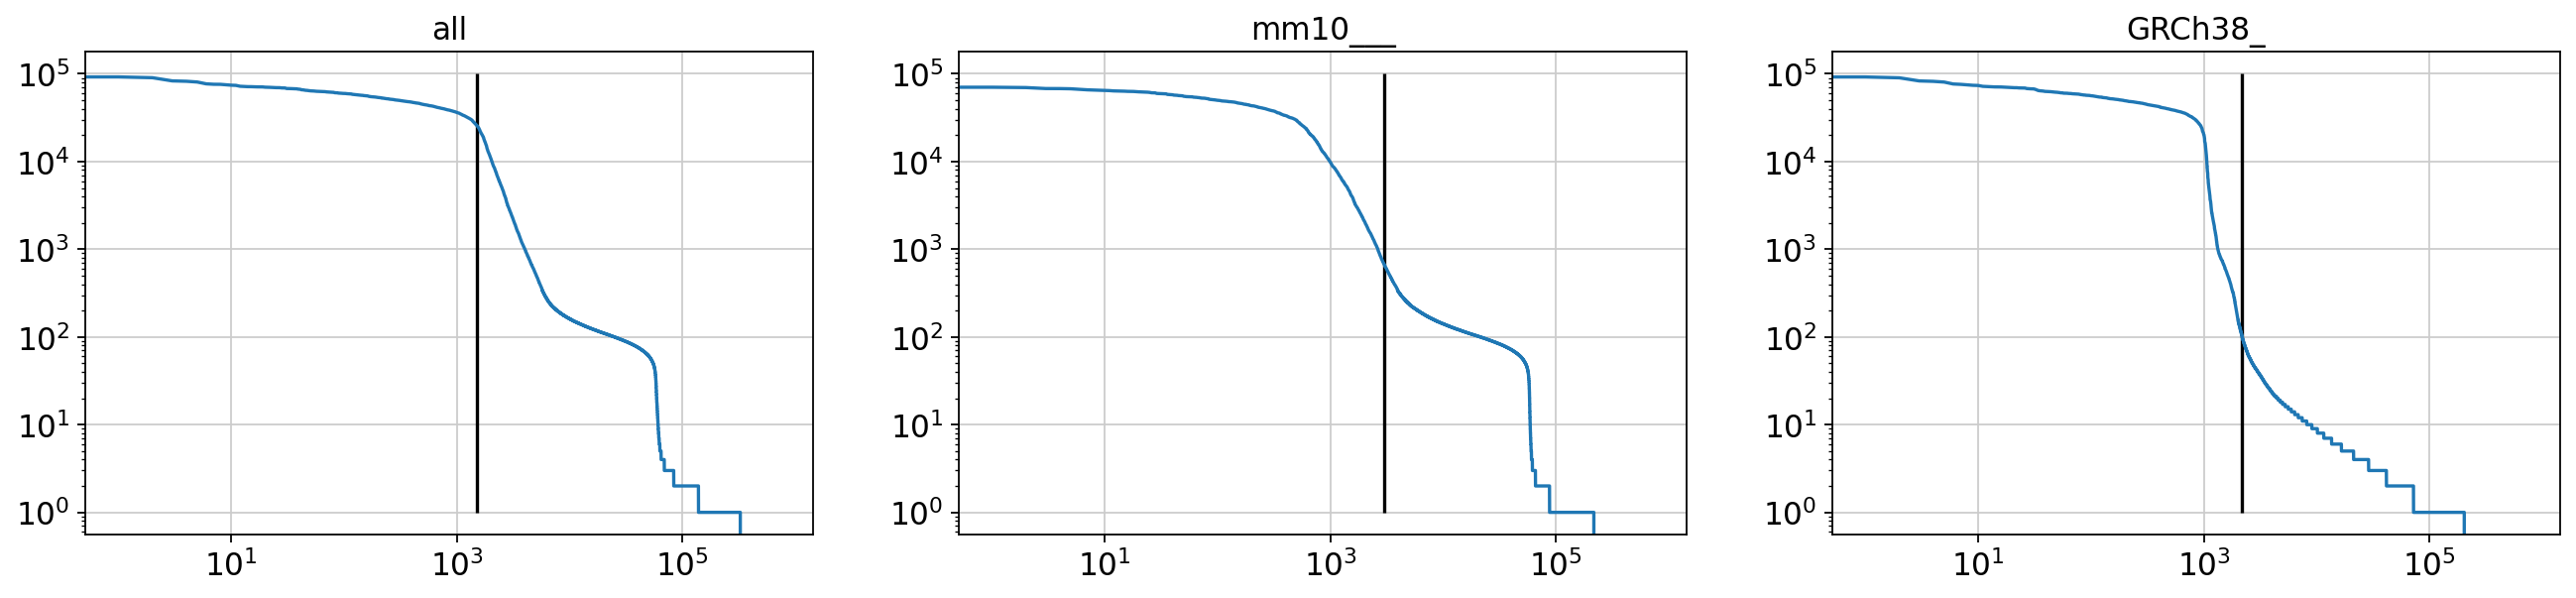

In [7]:
vlines=[1500, 3000, 2200]
fig, axes = plt.subplots(1,3,figsize=(20,4))
for var, ax, vline in zip(['all', 'mm10___', 'GRCh38_'], np.ravel(axes), vlines):
    if var == 'all': 
        ax.plot(np.sort(np.ravel(data['10x']['raw'].X.sum(1)))[::-1])
    else:
        ax.plot(np.sort(np.ravel(data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith(var)]].X.sum(1)))[::-1])
    ax.set_title(var)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.vlines(vline,1,1e5, color='k')

In [8]:
data['10x']['raw'].obs['mouse_counts'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].X.sum(1)
data['10x']['raw'].obs['human_counts'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('GRCh38_')]].X.sum(1)

Where to draw this is totally subjective. I realized with a value of `3000` I'm going deep into the mouse "knee", more than I would ordinarily.

In [9]:
mouse_thresh = 3000
human_thresh = 2200

In [10]:
mouse_only_cells = np.setdiff1d(data['10x']['raw'].obs['mouse_counts'].sort_values(ascending=False).index[:mouse_thresh].values,
                                data['10x']['raw'].obs['human_counts'].sort_values(ascending=False).index[:human_thresh].values)

In [11]:
data['10x']['mouse'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].copy()
data['10x']['mouse'].var_names = [i[7:] for i in data['10x']['mouse'].var_names]
data['10x']['mouse'] = data['10x']['mouse'][mouse_only_cells,:].copy()

In [12]:
data['XYZ']['mouse'] = data['XYZ']['raw'][data['XYZ']['raw'].obs['cell_call'] == 'M',:].copy()

In [13]:
data['10x']['mouse'].obs['mouse_counts']

AAACCTGAGAATGTGT-1    30535.0
AAACCTGAGGGTATCG-1      747.0
AAACCTGCAAGCTGAG-1    11212.0
AAACCTGCAGGGTTAG-1     9544.0
AAACCTGGTCGCTTCT-1     5291.0
                       ...   
TTTGTCAAGCCAACAG-1     4621.0
TTTGTCAAGTGGGTTG-1    48437.0
TTTGTCACATTACGAC-1     2598.0
TTTGTCAGTCCAGTGC-1     1466.0
TTTGTCATCAGGTTCA-1     2422.0
Name: mouse_counts, Length: 2900, dtype: float32

In [14]:
data['XYZ']['mouse'].obs['mouse_counts']

L20C1_P1A01F.CTCATACCTGCTACCT    5372.0
L20C1_P1A01F.GCGCTCCTTCCGCTAA    1256.0
L20C1_P1A02F.CGATAGCCTTATTGCT     700.0
L20C1_P1A02F.GTGCTCGTTAGGTTCT    1345.0
L20C1_P1A02F.TCAATTCGCGCACCGA     456.0
                                  ...  
L20C1_P4H12F.GGTAATGACTTGCAGA    3603.0
L20C1_P4H12F.GAGACATCCGGTATAC     544.0
L20C1_P4H12F.TTGGACGTGAGATAGT     934.0
L20C1_P4H12F.TCCACTGGAGTGTCGC     633.0
L20C1_P4H12F.TCCACCGTATGCGCTG     751.0
Name: mouse_counts, Length: 2389, dtype: float64

## Compare Counts

In [15]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), data['10x']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), data['XYZ']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])

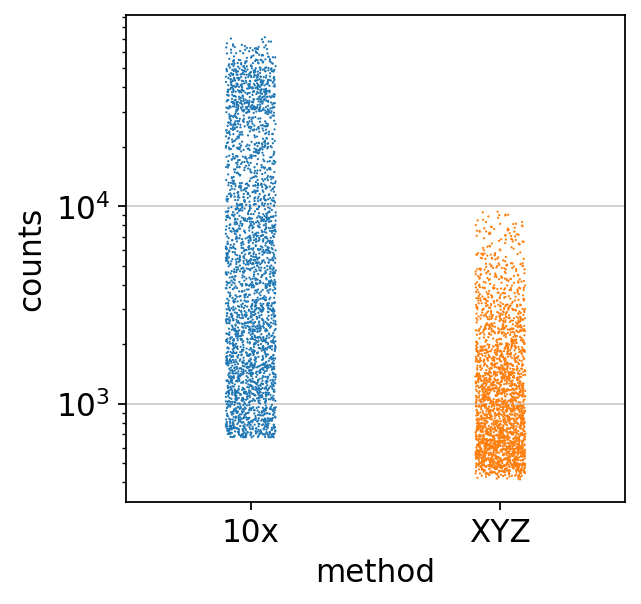

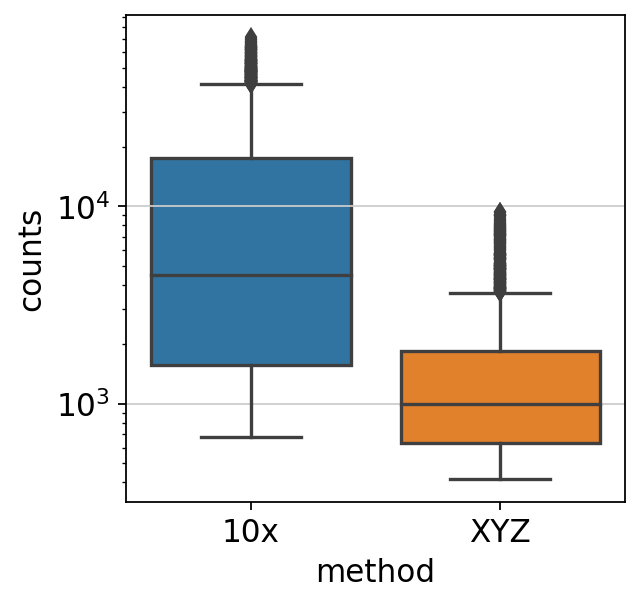

In [16]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.yscale('log')
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

## Filter for Percent Mito

In [17]:
genelist = data['10x']['mouse'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['10x']['mouse'][:, mito_genes].X, axis=1))

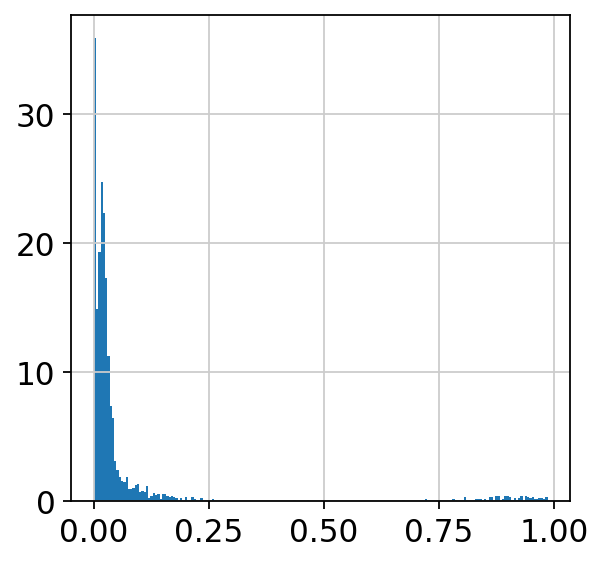

In [18]:
data['10x']['mouse'].obs['percent_mito'] = mito_counts / data['10x']['mouse'].obs['mouse_counts'].values
plt.hist(data['10x']['mouse'].obs['percent_mito'].values,bins=200,density=True);

In [19]:
data['10x']['mouse'] = data['10x']['mouse'][data['10x']['mouse'].obs['percent_mito'] < 0.25].copy()

In [20]:
data['10x']['mouse'] = data['10x']['mouse'][(np.ravel(data['10x']['mouse'].X.sum(1)) > 0),:].copy()

### Export Small Matrices

In [32]:
data['XYZ']['mouse'].var_names = [i[7:] for i in data['XYZ']['mouse'].var_names]

In [77]:
genes = np.intersect1d(data['XYZ']['mouse'].var_names.values, data['10x']['mouse'].var_names.values)

In [78]:
cells_XYZeq = np.random.choice(data['XYZ']['mouse'].obs_names.values, size=1000, replace=False)
cells_10x = np.random.choice(data['10x']['mouse'].obs_names.values, size=1000, replace=False)

In [79]:
df_10x_export = data['10x']['mouse'][cells_10x,:][:,genes].to_df()
df_XYZ_export = data['XYZ']['mouse'][cells_XYZeq,:][:,genes].to_df()

In [82]:
print(df_10x_export.shape)
print(df_XYZ_export.shape)

(1000, 23329)
(1000, 23329)


In [83]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), pd.Series(df_10x_export.sum(1), name='mouse_counts')), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), pd.Series(df_XYZ_export.sum(1), name='mouse_counts')), columns=['method', 'counts'])

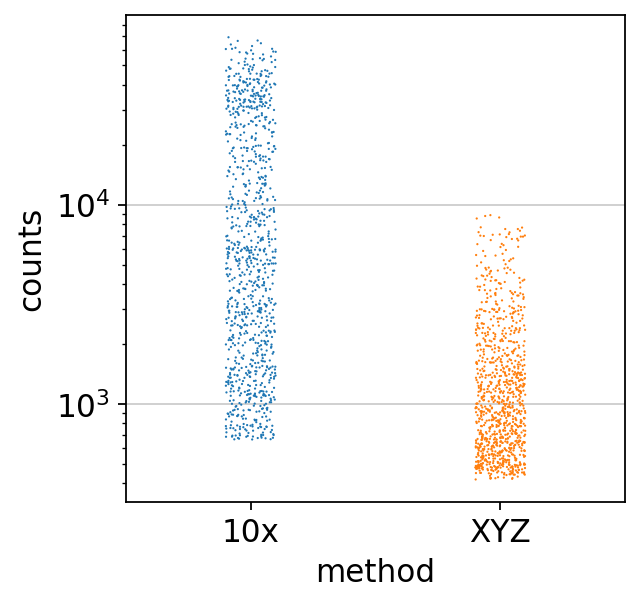

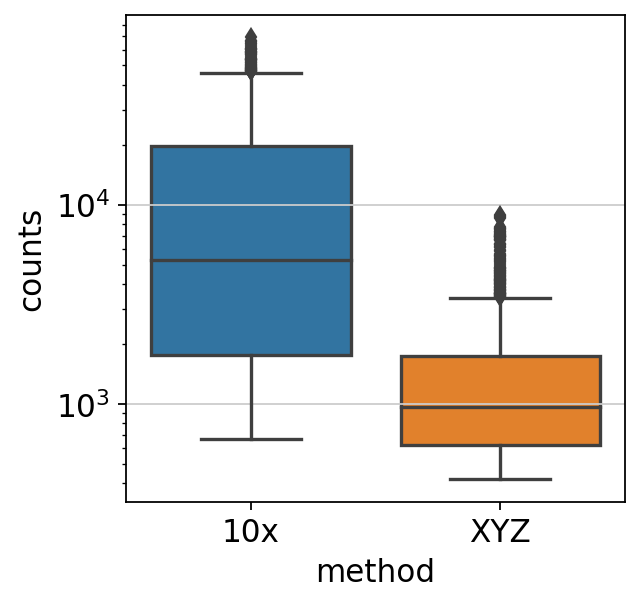

In [84]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.yscale('log')
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

In [85]:
df_10x_export.to_csv('/data/xyzeq/10x.counts.sample.csv')
df_XYZ_export.to_csv('/data/xyzeq/XYZ.counts.sample.csv')

## Downsample

Here, I downsample by subtracting one from the entire 10x matrix until the mean is within 5% of the XYZeq matrix. 

In [83]:
mean_xyz = data['XYZ']['mouse'].obs['mouse_counts'].mean()
mean_10x = 0
eps = mean_xyz*0.05 # within 5% of the mean
sp = data['10x']['mouse'].X.toarray()
counter = 0
while abs(mean_10x - mean_xyz) > eps:
    sp -= 1
    sp = np.where(sp < 0, 0, sp) # one begs the question: could i have just done np.where(sp > 0, sp - 1, 0)
    counter += 1
    mean_10x = sp.sum(1).mean()
#     print(counter)
    if counter % 100 == 0:
        print(mean_10x)

1859.2789


In [84]:
data['10x']['mouse_down'] = data['10x']['mouse'].copy()
data['10x']['mouse_down'].X = sp
data['10x']['mouse_down'].obs['mouse_counts'] = data['10x']['mouse_down'].X.sum(1)

In [85]:
data['10x']['mouse_down'].obs['mouse_counts'].mean()

1629.8768

In [86]:
data['XYZ']['mouse'].obs['mouse_counts'].mean()

1554.0916701548765

In [87]:
data['10x']['mouse_down'] = data['10x']['mouse_down'][(data['10x']['mouse_down'].obs['mouse_counts'] > 0),:].copy()

In [88]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), data['10x']['mouse_down'].obs['mouse_counts']), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), data['XYZ']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])

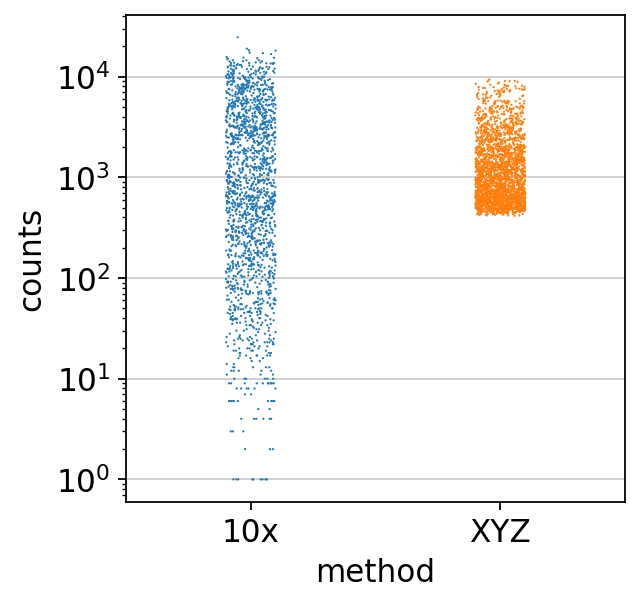

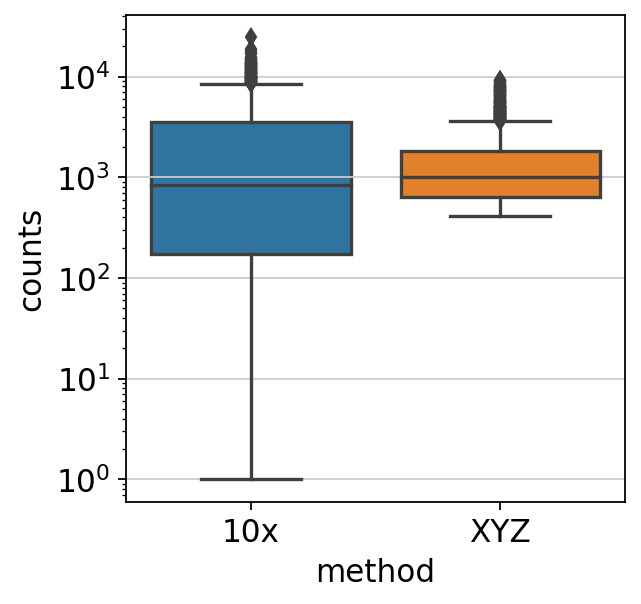

In [89]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.yscale('log')
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

The means might be the same, but unfortunately the medians are way off.

## Filter for Genes

In [90]:
def my_plot(ax, vals, tupe=None, thresh=None, max_y=None, low=1e-1, hi=2e5):
    ax.hist(vals,bins=np.logspace(np.log10(low),np.log10(hi), 300)) # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

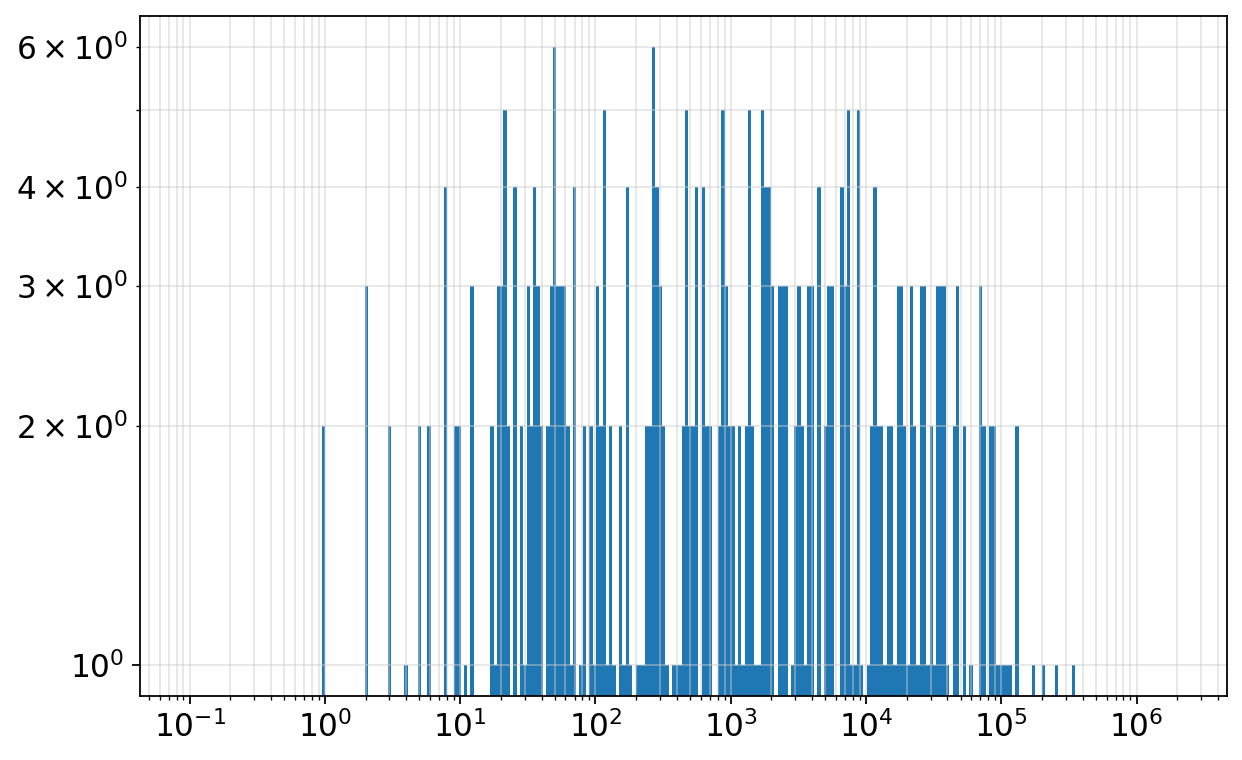

In [91]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
vals = sc.pp.filter_genes(data['10x']['mouse_down'], min_counts=0, inplace=False)[1] # total number of UMIs observed
my_plot(ax, vals, hi=2e6)
plt.tight_layout()

Going to leave this alone actually — no filtering.

In [92]:
data['10x']['mouse_down'].raw = data['10x']['mouse_down'].copy()

## Normalize and Log

In [93]:
sc.pp.normalize_per_cell(data['10x']['mouse_down'])
sc.pp.log1p(data['10x']['mouse_down'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Dimension Reduction and Clustering

In [94]:
data['10x']['mouse_down_unscaled'] = data['10x']['mouse_down'].copy()

In [95]:
sc.pp.scale(data['10x']['mouse_down'], max_value=10)

    ... clipping at max_value 10


computing PCA
    with n_comps=100
    finished (0:00:04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


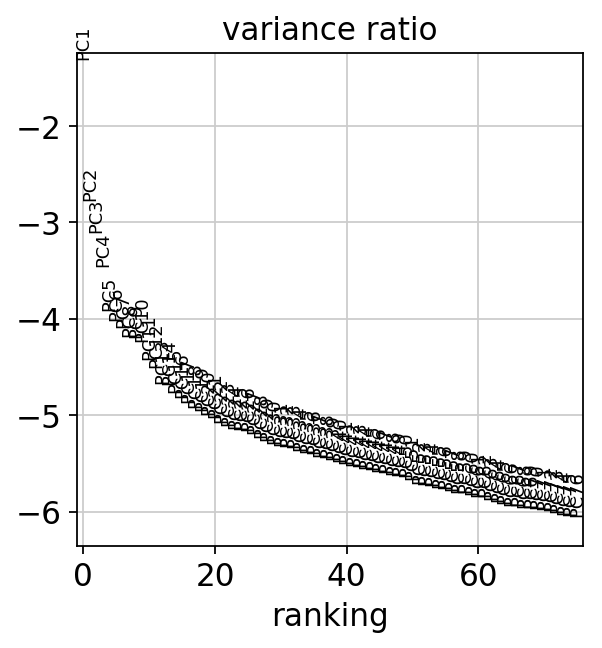

In [96]:
warnings.filterwarnings('ignore')
sc.pp.pca(data['10x']['mouse_down'],n_comps=100)
sc.pl.pca_variance_ratio(data['10x']['mouse_down'],log=True, n_pcs=75)
warnings.filterwarnings('default')

In [97]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(data['10x']['mouse_down'], n_neighbors=15, n_pcs=30) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [98]:
sc.tl.umap(data['10x']['mouse_down'])

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [99]:
sc.tl.tsne(data['10x']['mouse_down'], n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1777 samples in 0.004s...
[t-SNE] Computed neighbors for 1777 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1777
[t-SNE] Computed conditional probabilities for sample 1777 / 1777
[t-SNE] Mean sigma: 0.000003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.464622
[t-SNE] KL divergence after 1000 iterations: 0.627936
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:05)


In [100]:
data['10x']['mouse_down']

AnnData object with n_obs × n_vars = 1777 × 31053
    obs: 'mouse_counts', 'human_counts', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [101]:
sc.tl.leiden(data['10x']['mouse_down'], resolution=0.1)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


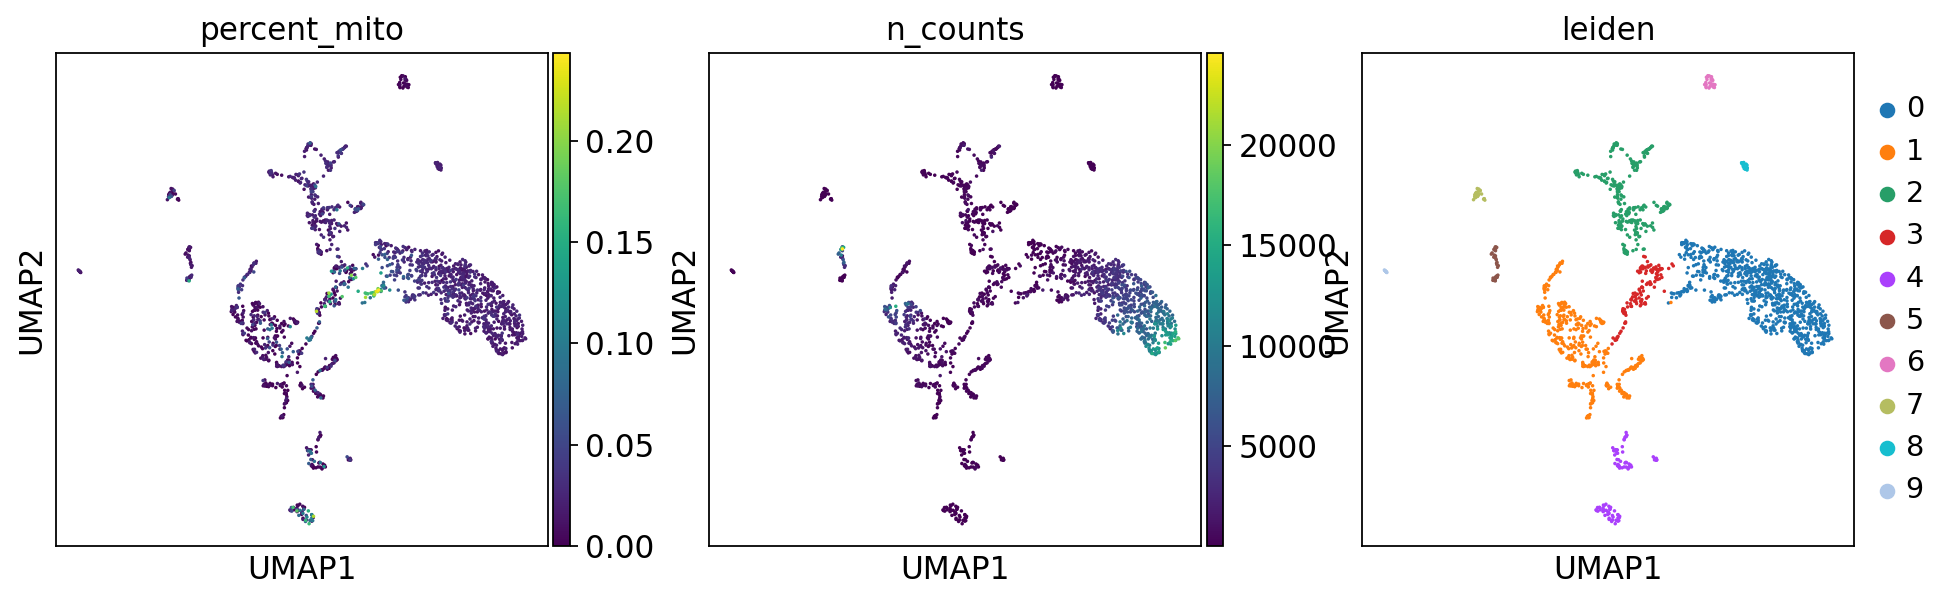

In [102]:
sc.pl.umap(data['10x']['mouse_down'],color=['percent_mito', 'n_counts', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

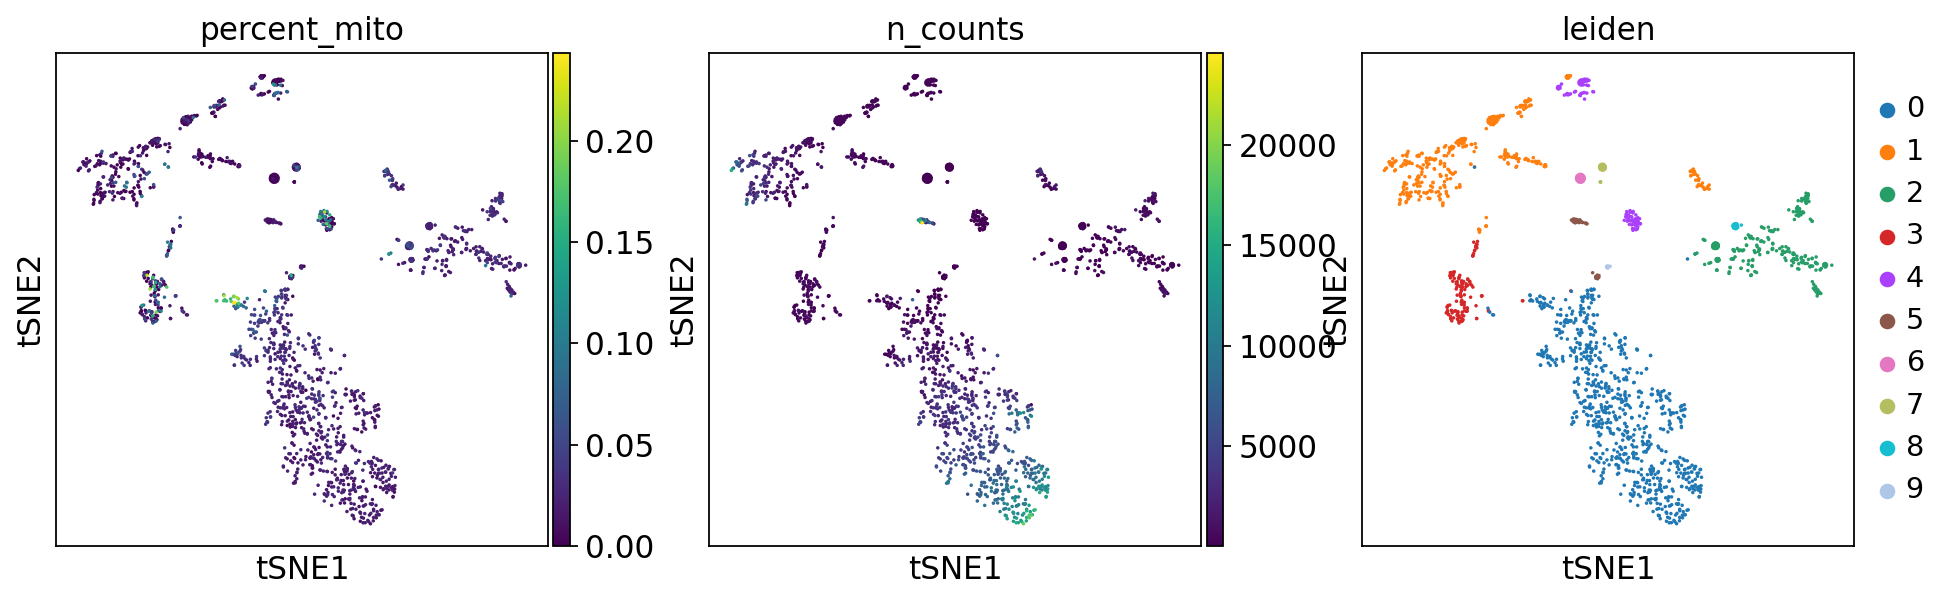

In [103]:
sc.pl.tsne(data['10x']['mouse_down'],color=['percent_mito', 'n_counts', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

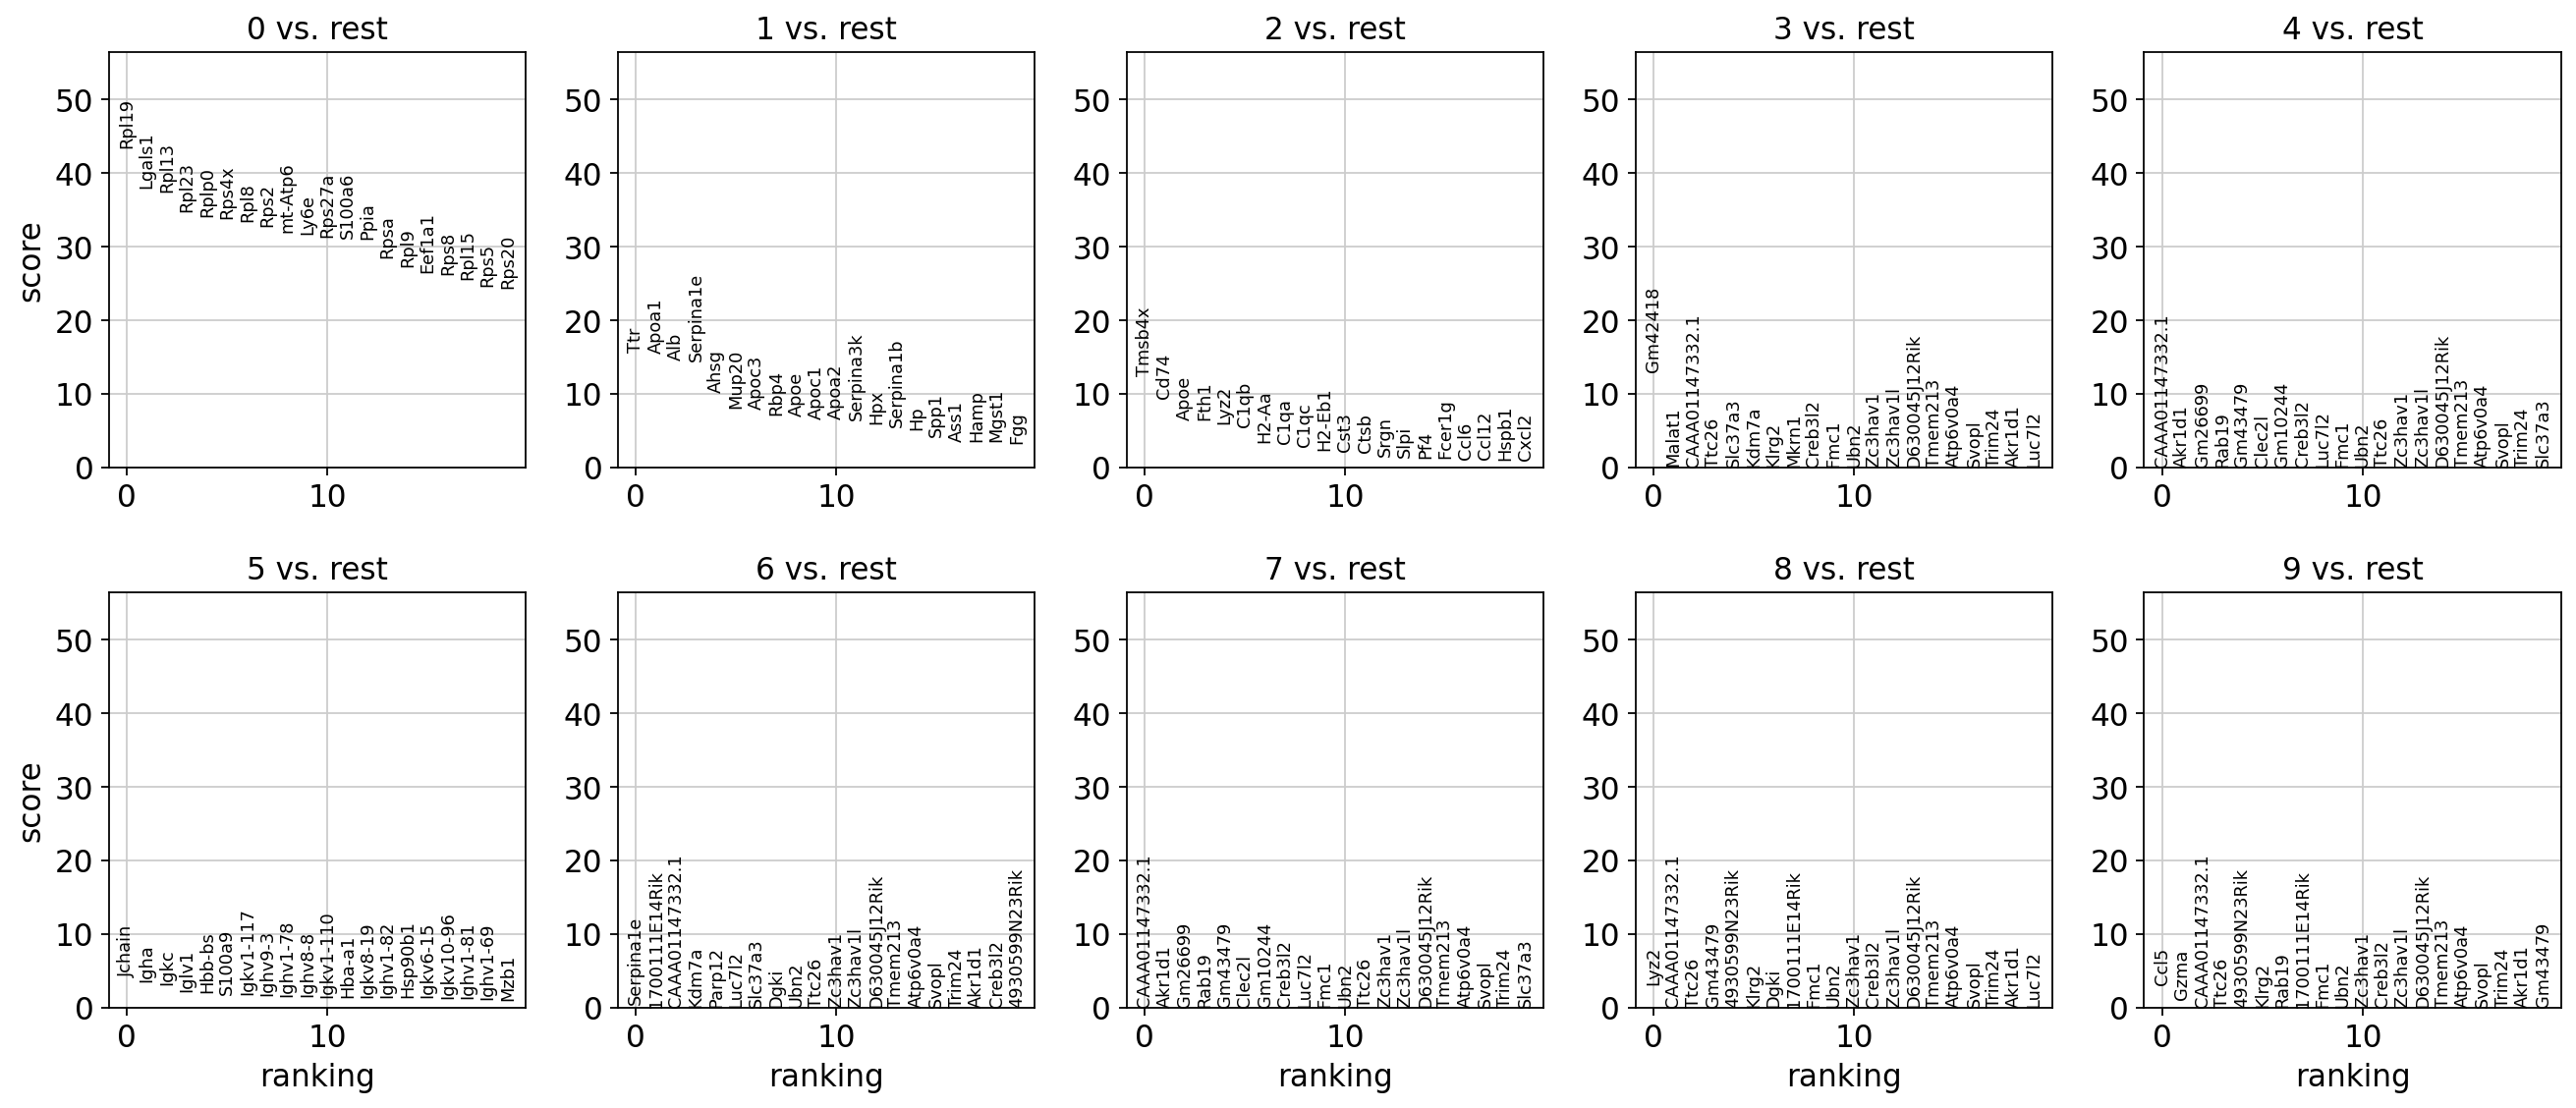

In [104]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['10x']['mouse_down'], groupby='leiden', n_genes=20)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['10x']['mouse_down'], ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [105]:
for i in data['10x']['mouse_down'].obs['leiden'].dtype.categories:
    print(i + ': ' + ', '.join(data['10x']['mouse_down'].uns['rank_genes_groups']['names'][i][:10]))

0: Rpl19, Lgals1, Rpl13, Rpl23, Rplp0, Rps4x, Rpl8, Rps2, mt-Atp6, Ly6e
1: Ttr, Apoa1, Alb, Serpina1e, Ahsg, Mup20, Apoc3, Rbp4, Apoe, Apoc1
2: Tmsb4x, Cd74, Apoe, Fth1, Lyz2, C1qb, H2-Aa, C1qa, C1qc, H2-Eb1
3: Gm42418, Malat1, CAAA01147332.1, Ttc26, Slc37a3, Kdm7a, Klrg2, Mkrn1, Creb3l2, Fmc1
4: CAAA01147332.1, Akr1d1, Gm26699, Rab19, Gm43479, Clec2l, Gm10244, Creb3l2, Luc7l2, Fmc1
5: Jchain, Igha, Igkc, Iglv1, Hbb-bs, S100a9, Igkv1-117, Ighv9-3, Ighv1-78, Ighv8-8
6: Serpina1e, 1700111E14Rik, CAAA01147332.1, Kdm7a, Parp12, Luc7l2, Slc37a3, Dgki, Ubn2, Ttc26
7: CAAA01147332.1, Akr1d1, Gm26699, Rab19, Gm43479, Clec2l, Gm10244, Creb3l2, Luc7l2, Fmc1
8: Lyz2, CAAA01147332.1, Ttc26, Gm43479, 4930599N23Rik, Klrg2, Dgki, 1700111E14Rik, Fmc1, Ubn2
9: Ccl5, Gzma, CAAA01147332.1, Ttc26, 4930599N23Rik, Klrg2, Rab19, 1700111E14Rik, Fmc1, Ubn2


In [106]:
clusts = [4]

In [107]:
sub_adatas = dict() # put the new subsetted adata objects in a dictionary of adatas
for clust in clusts:
    sub_adatas[str(clust)] = data['10x']['mouse_down'][data['10x']['mouse_down'].obs['leiden'] == str(clust)].copy()

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


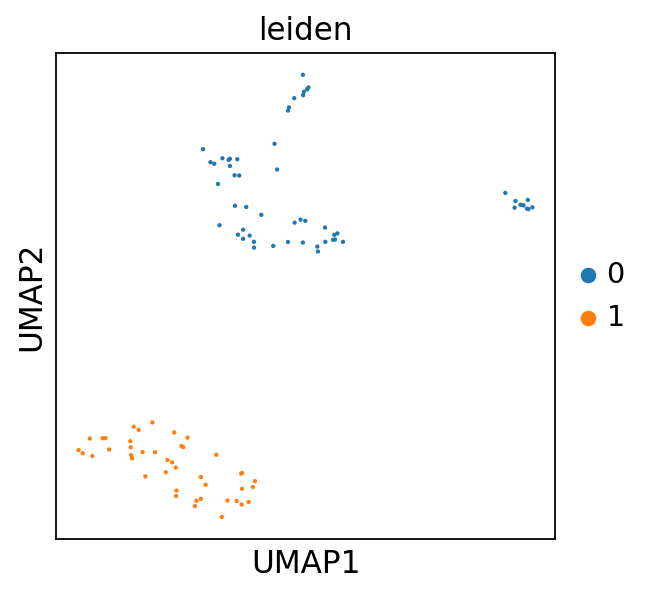

In [108]:
sc.tl.leiden(sub_adatas['4'], resolution=0.01) # subcluster them using Leiden
sc.pl.umap(sub_adatas['4'], color='leiden', size=15)

In [109]:
def sub_cluster_mapper(adata, sub_adatas):
    '''
    This takes in the adata object and inserts a new leiden column in the `.obs`. 
    
    This function is really convoluted and there's probably a better, simpler way to do it,
    but it should theoretically work for any number of subclusters
    '''
    # ideally you'd make a copy of the adata object here, so we don't have to change the original
    # this would be in case we want to run it multiple times, perhaps the resolutions we put in didn't subset the clusters like we had hoped
    # and we need to run multiple times to adjust the resolution slightly
    
    # this block is to figure out that there are two new subclusters and they should be named 8, 9
    total_new_clusts = 0
    old_clusts = sub_adatas.keys()
    for sub_adata in sub_adatas:
        total_new_clusts += sub_adatas[sub_adata].obs['leiden'].astype(int).unique().max() + 1
    total_added_clusts = total_new_clusts - len(sub_adatas)
    new_clust_names_start = max(adata.obs['leiden'].astype(int))+1
    new_added_clust_names = [str(i) for i in range(new_clust_names_start,
                                                   new_clust_names_start + total_added_clusts)]
    
    # this block is to build a new list of leiden clusters from the old one 
    new_leiden = list()
    leiden_col = adata.obs['leiden'].copy()

    # this builds the new leiden cluster list, now adding a .1, .2, etc. to each new cluster
    for obs in leiden_col.index:
        clust_name = leiden_col.loc[obs]
        if clust_name not in old_clusts or sub_adatas[clust_name].obs.loc[obs, 'leiden'] == '0':
            new_leiden.append(clust_name)
        else:
            new_leiden.append(clust_name + '.%s' % sub_adatas[clust_name].obs.loc[obs,'leiden'])

    # this renames the .1, .2, etc clusters to the new, better names I came up with above (8 and 9)
    new_leiden = pd.Series(new_leiden, index=adata.obs_names)
    added_clusts = np.setdiff1d(new_leiden,adata.obs['leiden'])
    new_leiden.replace(dict(zip(added_clusts, new_added_clust_names)), inplace=True)
    
    # replace the old leiden column, must do these steps sequentially 
    adata.obs['leiden'] = new_leiden.astype(int) # to order the clusters by number
    adata.obs['leiden'] = new_leiden.astype(str) # to convert to string as normal
#     adata.obs['leiden'] = new_leiden.astype('category') # don't do this, it messes things up, just let scanpy do it as it plots
    return adata

In [110]:
data['10x']['mouse_down'] = sub_cluster_mapper(data['10x']['mouse_down'], sub_adatas)

... storing 'leiden' as categorical


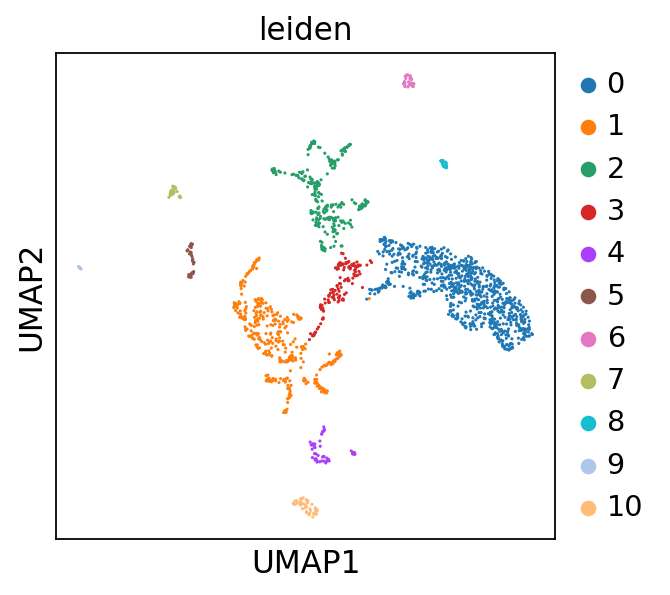

In [111]:
sc.pl.umap(data['10x']['mouse_down'], color=['leiden'], size=8, palette=sc.pl.palettes.vega_20_scanpy)

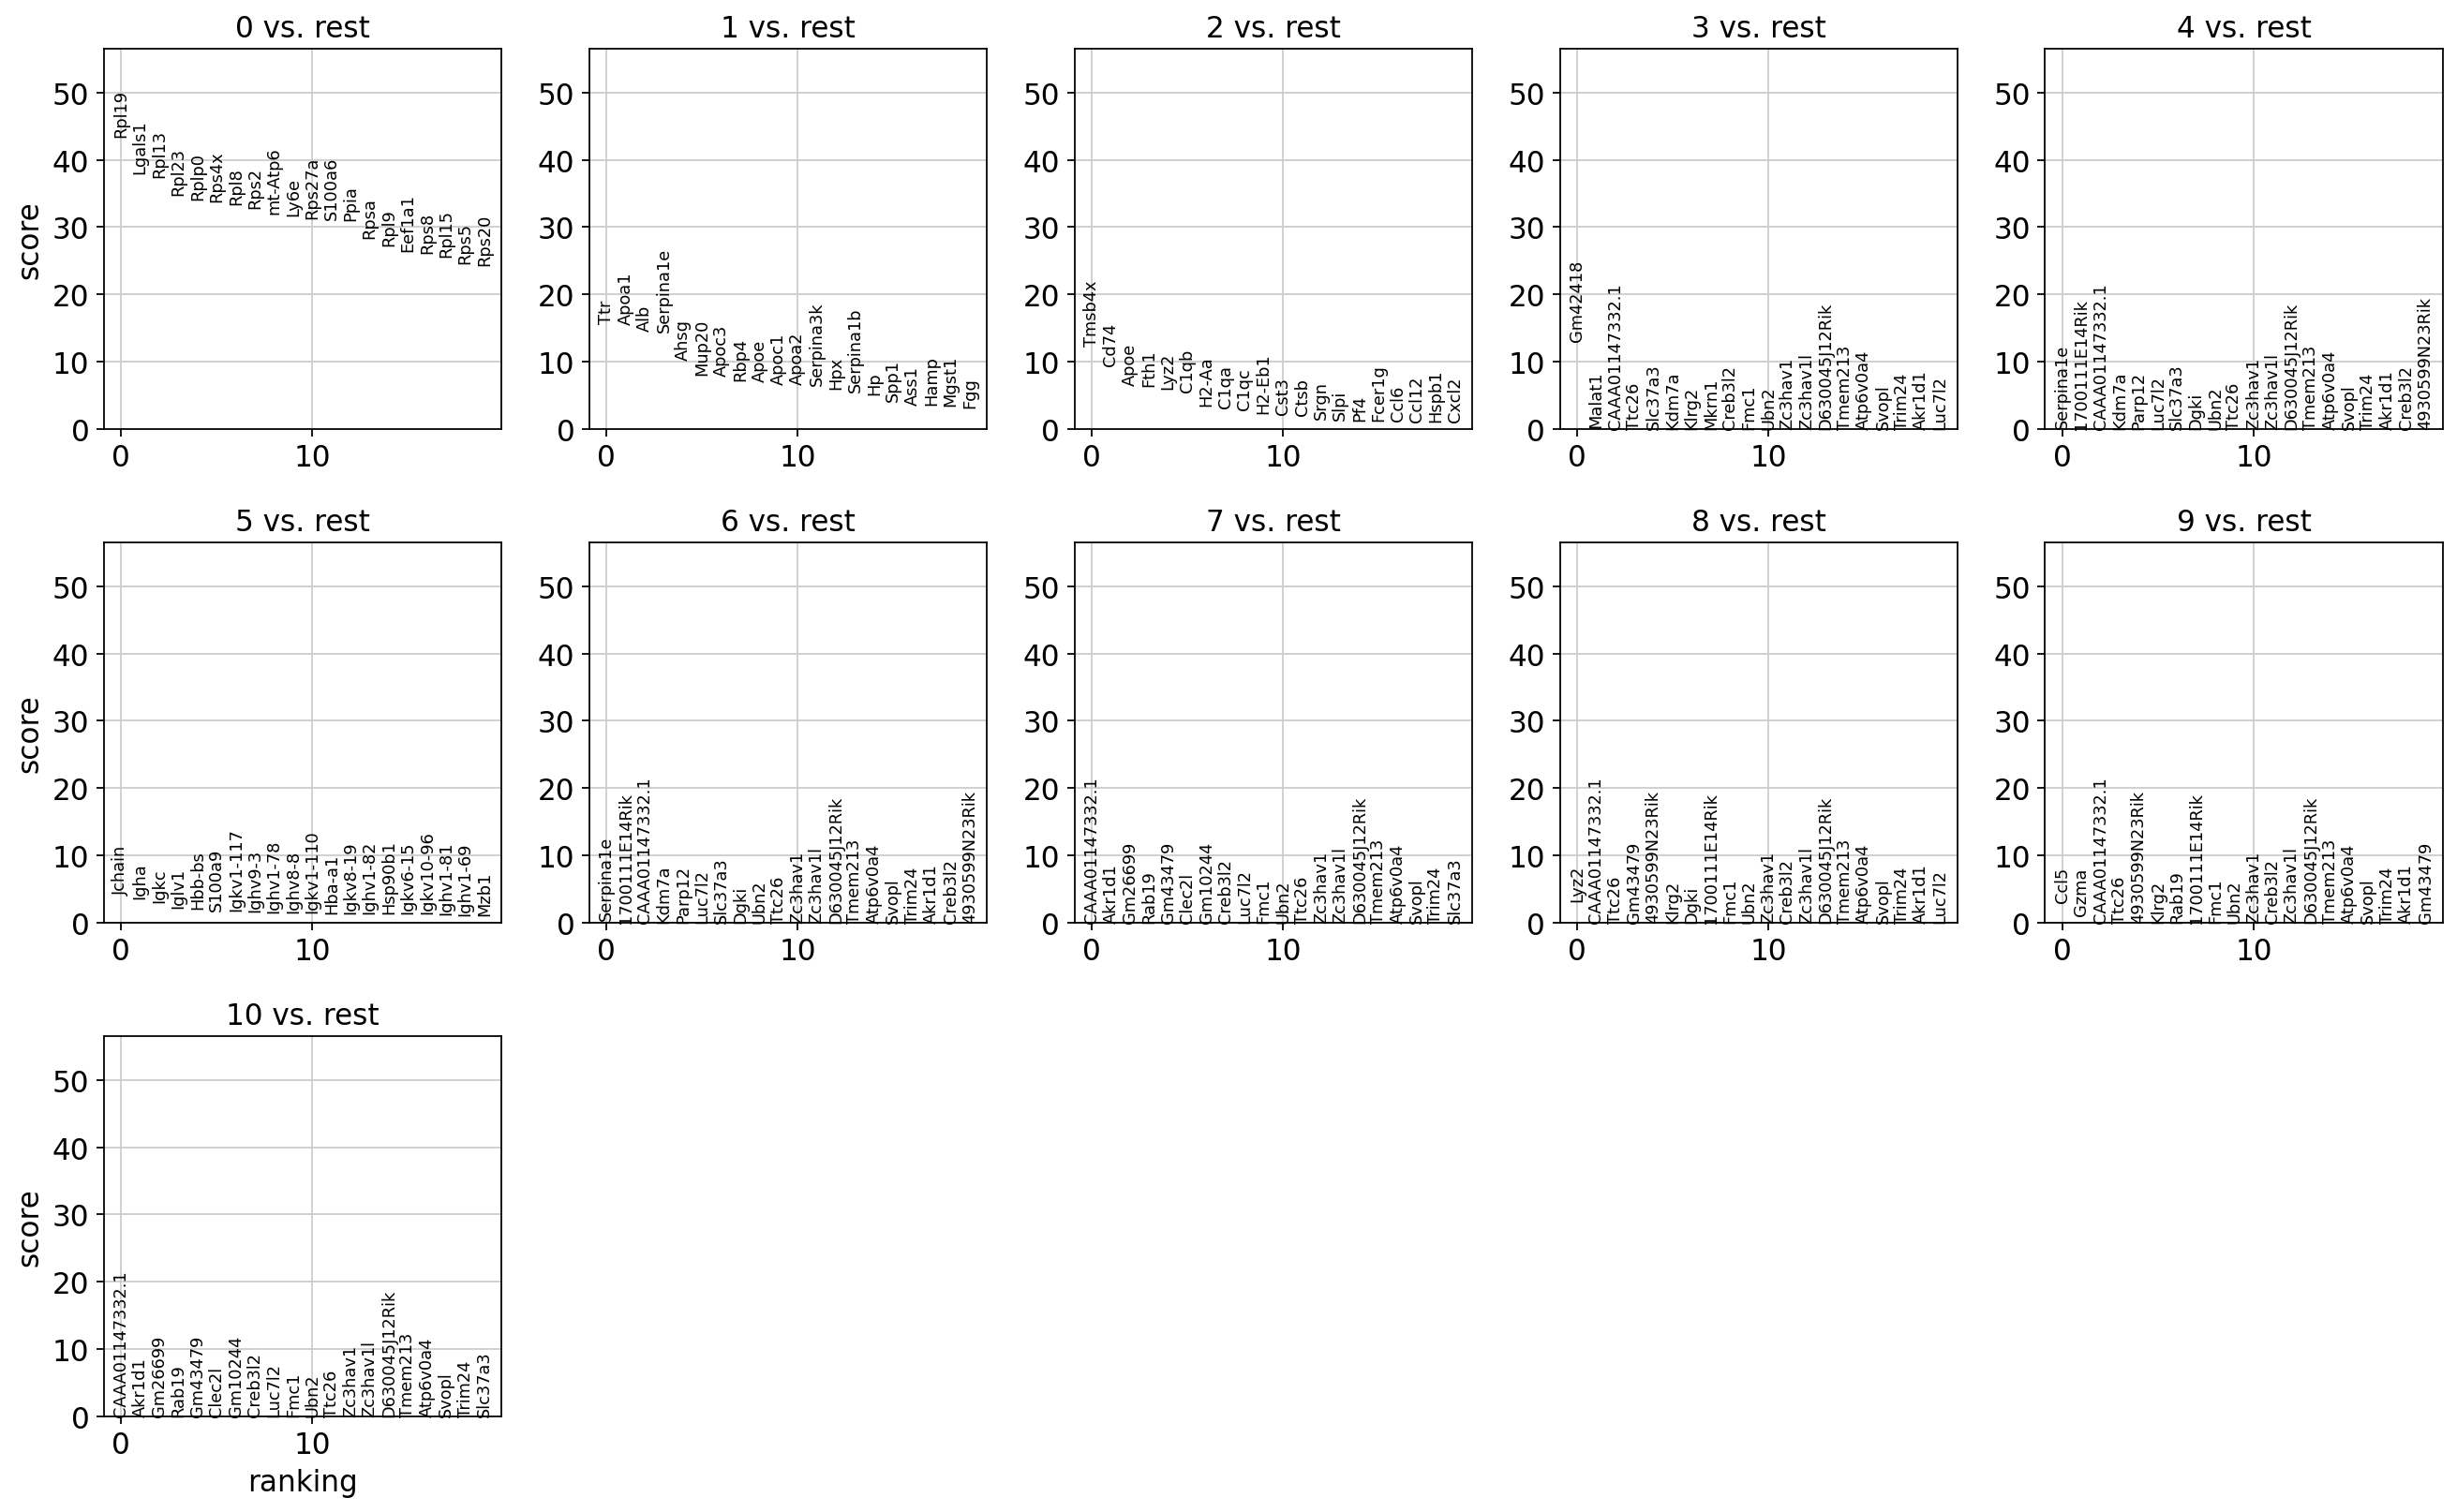

In [112]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['10x']['mouse_down'], groupby='leiden', n_genes=20)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['10x']['mouse_down'], ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [117]:
def low_de_make(adata, p=0.2, p_of='any', cov='leiden'):
    '''
    adata = adata object with a raw attribute
    p = percentage of cells that should be expressing a gene for it to be reported
    p_of = when subsetting genes to report, at least p percent of cells in ANY cluster ('any') \n
    should be expressing the gene, or only in the provided cluster
    '''
    X = adata.raw.X.copy()
    clusts = adata.obs[cov].dtype.categories
    df = pd.DataFrame(0,index=clusts, columns=adata.raw.var_names.values,dtype=np.float16)
    for clust in clusts:
        clustbool = (adata.obs[cov] == clust).values
        clustX = X[clustbool]
        try:
            clustX = clustX.tocsc()
        except AttributeError:
            from scipy.sparse import csc_matrix
            clustX = csc_matrix(clustX)
        df.loc[clust] = clustX.getnnz(axis=0)/clustX.shape[0]
    if p_of == 'any':
        df = df.iloc[:,df.apply(lambda x: np.any(x > p), axis=0, raw=True).values]
    else:
        df = df.iloc[:,(df.loc[p_of] > p).values]
    return df

def low_de_compare(df, clust, compare=None):
    if type(compare) == type(None): 
        return (df.loc[clust]/df[~(df.index == clust)].mean()).sort_values(ascending=False)
    elif type(compare) == list:
        return (df.loc[clust]/df[(df.index.isin(compare))].mean()).sort_values(ascending=False)

In [159]:
g1 = ['10']
g2 = [i for i in data['10x']['mouse_down'].obs['leiden'].dtype.categories if i not in g1]

In [163]:
df = low_de_make(data['10x']['mouse_down'], p=0.05, p_of=g1[0], cov='leiden')

In [164]:
de_genes = low_de_compare(df, g1[0], compare=g2)

In [165]:
print(de_genes[:50])

Alb    5.75
dtype: float16


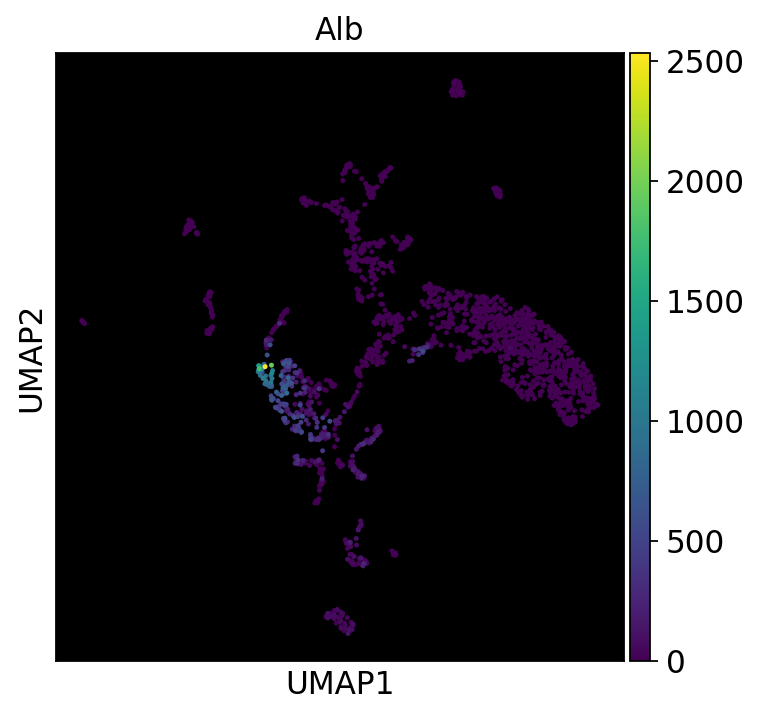

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
for color, ax in zip(['Alb'], [ax]):
    ax.set_facecolor('black')
    sc.pl.umap(data['10x']['mouse_down'], color=color, ax=ax, show=False, return_fig=False, size=20)

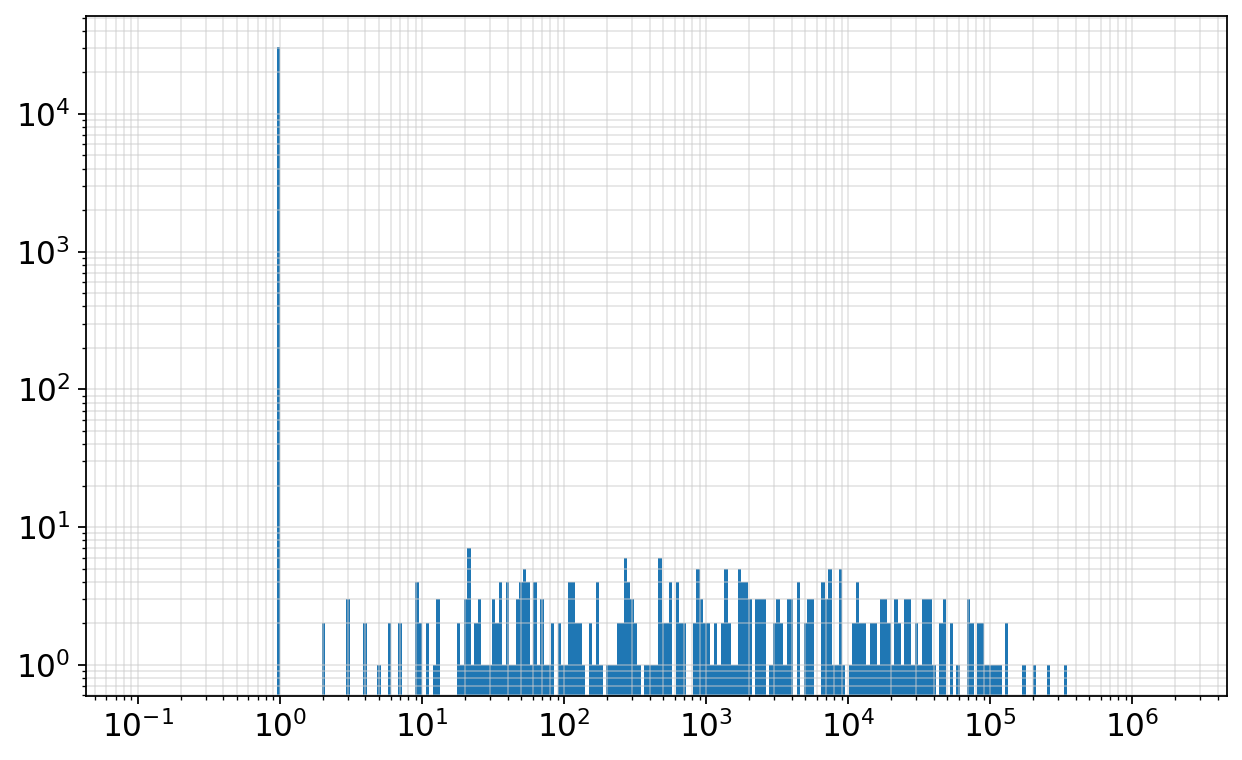

In [172]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
my_plot(ax, data['10x']['mouse_down'].raw.X.sum(0) + 1 , hi=2e6)
plt.tight_layout()

In [173]:
(data['10x']['mouse_down'].raw.X.sum(0) > 0).sum()

346

This just isn't enough genes to do anything with.